<a href="https://colab.research.google.com/github/fernandofsilva/Articles/blob/main/notebooks/telework_adoption_in_time_of_pandemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telework adoption in time of pandemic



## Setup

In [66]:
#@title
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

import pandas as pd

import pprint

In [67]:
#@title
def getData(file: str, worksheet: str) -> pd.DataFrame:
    
    # Open file and worksheet
    worksheet = gc.open(file).worksheet(worksheet)
    
    # get_all_values gives a list of rows
    rows = worksheet.get_all_values()[1:]
    cols = worksheet.get_all_values()[0]

    # Convert to a DataFrame and render
    data = pd.DataFrame.from_records(data=rows, columns=cols)
    
    return data

In [68]:
#@title import data from Gsheets

data = getData('COVID-19 (Responses formatted)', 'responses')
hypothesis = getData('COVID-19 (Responses formatted)', 'hypothesis')

data.head()

,_excluded,Timestamp,Qual sua idade,Informe seu gênero.,Qual a sua escolaridade?,Você exerce algum cargo de gestão?,"Qual a localização geográfica do seu trabalho? ex. Estado: São Paulo, Cidade: Barueri",Qual a localização geográfica do seu trabalho? Cidade,Qual a localização geográfica do seu trabalho? Estado,Com qual frequência você trabalhava remoto antes da pandemia de Corona Vírus? Por favor não considere trabalho remoto executá-lo das instalações de algum cliente.,Antes de iniciar o trabalho remoto você tinha interação presencial com outros colegas de trabalho ou clientes?,"Há quanto tempo você já está em trabalho remoto, sem ir a empresa ou cliente? (dias)",A iniciativa de trabalhar remoto foi sua ou da empresa?,Qual a sua maior dificuldade ao trabalhar remoto?,Qual você considera ser a ferramenta mais importante para trabalhar em home office?,Você considera que o trabalho remoto assegurará o seu emprego.,Você considera que teve ganho de produtividade com o trabalho remoto.,Você considera que tem as condições adequadas para realizar o seu trabalho remoto,"Você considera que conseguiu criar uma rotina de trabalho (horário de início, término, refeições e intervalos).",Você acredita que pode desenvolver novos negócios ou transformar os atuais com o trabalho remoto.,Você considera que tem conseguido realizar plenamente o seu trabalho estando remoto.,Você considera que o trabalho remoto garante o pleno funcionamento da sua empresa.,Você tem dificuldades em lidar com ferramentas tecnológicas.,Você acredita que pode aprender a usar todas as ferramentas tecnológicas necessárias para realizar o seu trabalho remoto.,Você consegue fazer uso de todas as funcionalidades das ferramentas tecnológicas que necessita durante o seu trabalho remoto.,Você considera que tem as ferramentas necessárias para trabalhar remoto.,Você tem suporte técnico da empresa nesse período de trabalho remoto.,Você considera que o suporte técnico esclarece plenamente as suas dúvidas. (8 se não usou),"Você acredita que após o retorno ao trabalho presencial, as reuniões a distância serão mais frequentes.",Você consegue se manter motivado durante o período de trabalho remoto.,A sua interação com o time foi prejudicada no trabalho remoto (recurso),Você tem contato regular com o seu gestor no período de trabalho remoto,Você tem recebido metas e objetivos claros e adequados ao trabalho remoto,Você tem maior autonomia para tomar as decisões necessárias nesse período de trabalho remoto.,Você tem recebido feedback com maior frequência nesse período de trabalho remoto.,Você acredita que o seu time está comprometido no trabalho remoto da mesma forma que antes. (Recurso),Você acredita que o seu time de trabalho tem sido eficiente no trabalho remoto da mesma forma que antes. (Recurso),Você concorda que o seu gestor consegue coordenar o time remoto de forma eficiente.,Você sente que consegue manter o time motivado durante o período de trabalho remoto.,A sua interação com o time foi prejudicada no período de trabalho remoto (gestor),Você tem contato regular com os seus recursos no período de trabalho remoto,Você tem adequado as metas e objetivos para que o trabalho seja realizado remotamente.,Você tem dado mais autonomia para os seus recursos que estão em trabalho remoto.,Você acredita que o seu time está comprometido no trabalho remoto da mesma forma que antes. (Gestor),Você acredita que o seu time de trabalho tem sido eficiente no trabalho remoto da mesma forma que antes. (Gestor),Você sente que tem conseguido coordenar o time remoto de forma eficiente.
0,,4/2/2020 11:17:42,18,Feminino,Ensino Superior,Não,"Cidade:dema, Estado: São Paulo",Diadema,São Paulo,Eventualmente,Todos os,14,Iniciativa própria,"Manter o foco, além de alguns contatos que na ...",Telefone,3,6,4,1,7,2,2,7,1,2,2,3,7,6,3,7,2,3,2,7,7,5,6,,,,,,,,
1,,4/2/2020 13:47:49,18,Feminino,Ensino Superior,Não,"Cidade: Santo André, Estado: São Paulo",Santo André,São Paulo,Nunca,Todos os,14,Iniciativa da empresa,Conexão

## Preprocessing information

The columns names are long and its difficult to handle, so it was encoded in simple names.

In [69]:
#@title encoding features names

enc_cols = {}

for index, col in enumerate(data.columns):
    enc_cols[f'column_{index}'] = col

data.columns = enc_cols.keys()

data.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45
0,,4/2/2020 11:17:42,18,Feminino,Ensino Superior,Não,"Cidade:dema, Estado: São Paulo",Diadema,São Paulo,Eventualmente,Todos os,14,Iniciativa própria,"Manter o foco, além de alguns contatos que na ...",Telefone,3,6,4,1,7,2,2,7,1,2,2,3,7,6,3,7,2,3,2,7,7,5,6,,,,,,,,
1,,4/2/2020 13:47:49,18,Feminino,Ensino Superior,Não,"Cidade: Santo André, Estado: São Paulo",Santo André,São Paulo,Nunca,Todos os,14,Iniciativa da empresa,Conexão em sistema,Internet e Telefone,4,7,7,3,1,5,4,1,7,7,7,7,7,1,1,7,7,7,7,1,7,3,7,,,,,,,,
2,,4/2/2020 13:57:51,18,Feminino,Ensino Médio,Não,"Cidade: São Paulo, Estado: São Paulo",São Paulo,São Paulo,Nunca,Todos os,15,Iniciativa da empresa,A lentidão do sistema e problemas em casa como...,O computador,4,5,2,1,2,3,3,6,2,1,2,1,8,4,2,2,2,1,6,2,1,1,1,,,,,,,,
3,,4/2/2020 13:17:22,18,Masculino,Ensino Médio,Não,"Cidade: Guarulhos, Estado: São Paulo",Guarulhos,São Paulo,Nunca,Todos os,21,Iniciativa da empresa,Comunicação com colegas de trabalho e concentr...,Ferramentas de comunicação como Skype,3,6,4,3,5,5,3,7,6,5,6,4,8,3,7,3,5,7,5,5,2,2,2,,,,,,,,
4,,4/2/2020 13:02:28,18,Feminino,Ensino Superior,Não,"Cidade: São Paulo, Estado: São Paulo",São Paulo,São Paulo,Todos os,Todos os,22,Iniciativa da empresa,Concentração,"Slack e Gmail, para me comunicar com a empresa...",3,4,2,2,3,2,2,6,2,2,2,2,2,1,2,6,2,2,4,2,1,1,1,,,,,,,,


Below, a print with the encoded label and the correspond original name.

In [70]:
#@title columns enconded
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(enc_cols)

{   'column_0': '_excluded',
    'column_1': 'Timestamp',
    'column_10': 'Antes de iniciar o trabalho remoto você tinha interação '
                 'presencial com outros colegas de trabalho ou clientes?',
    'column_11': 'Há quanto tempo você já está em trabalho remoto, sem ir a '
                 'empresa ou cliente? (dias)',
    'column_12': 'A iniciativa de trabalhar remoto foi sua ou da empresa?',
    'column_13': 'Qual a sua maior dificuldade ao trabalhar remoto?',
    'column_14': 'Qual você considera ser a ferramenta mais importante para '
                 'trabalhar em home office?',
    'column_15': 'Você considera que o trabalho remoto assegurará o seu '
                 'emprego.',
    'column_16': 'Você considera que teve ganho de produtividade com o '
                 'trabalho remoto.',
    'column_17': 'Você considera que tem as condições adequadas para realizar '
                 'o seu trabalho remoto',
    'column_18': 'Você considera que conseguiu criar uma roti

In [71]:
#@title convert columns to numeric
cols = [f'column_{num}' for num in range(15, 46)]
data[cols] = data[cols].apply(pd.to_numeric, downcast='float')
data.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45
0,,4/2/2020 11:17:42,18,Feminino,Ensino Superior,Não,"Cidade:dema, Estado: São Paulo",Diadema,São Paulo,Eventualmente,Todos os,14,Iniciativa própria,"Manter o foco, além de alguns contatos que na ...",Telefone,3.0,6.0,4.0,1.0,7.0,2.0,2.0,7.0,1.0,2.0,2.0,3.0,7.0,6.0,3.0,7.0,2.0,3.0,2.0,7.0,7.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,4/2/2020 13:47:49,18,Feminino,Ensino Superior,Não,"Cidade: Santo André, Estado: São Paulo",Santo André,São Paulo,Nunca,Todos os,14,Iniciativa da empresa,Conexão em sistema,Internet e Telefone,4.0,7.0,7.0,3.0,1.0,5.0,4.0,1.0,7.0,7.0,7.0,7.0,7.0,1.0,1.0,7.0,7.0,7.0,7.0,1.0,7.0,3.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,4/2/2020 13:57:51,18,Feminino,Ensino Médio,Não,"Cidade: São Paulo, Estado: São Paulo",São Paulo,São Paulo,Nunca,Todos os,15,Iniciativa da empresa,A lentidão do sistema e problemas em casa como...,O computador,4.0,5.0,2.0,1.0,2.0,3.0,3.0,6.0,2.0,1.0,2.0,1.0,8.0,4.0,2.0,2.0,2.0,1.0,6.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,4/2/2020 13:17:22,18,Masculino,Ensino Médio,Não,"Cidade: Guarulhos, Estado: São Paulo",Guarulhos,São Paulo,Nunca,Todos os,21,Iniciativa da empresa,Comunicação com colegas de trabalho e concentr...,Ferramentas de comunicação como Skype,3.0,6.0,4.0,3.0,5.0,5.0,3.0,7.0,6.0,5.0,6.0,4.0,8.0,3.0,7.0,3.0,5.0,7.0,5.0,5.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,4/2/2020 13:02:28,18,Feminino,Ensino Superior,Não,"Cidade: São Paulo, Estado: São Paulo",São Paulo,São Paulo,Todos os,Todos os,22,Iniciativa da empresa,Concentração,"Slack e Gmail, para me comunicar com a empresa...",3.0,4.0,2.0,2.0,3.0,2.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,6.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
#@title split data
manager_cols = [f'column_{index}' for index in [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 38, 39, 40, 41, 42, 43, 44, 45]]
man = data.loc[data[manager_cols[-1]].notnull(), manager_cols]

resource_cols = [f'column_{index}' for index in [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]]
rec = data.loc[data[resource_cols[-1]].notnull(), resource_cols]

## Factor Analysis

Factor Analysis (FA) is an exploratory data analysis method used to search influential underlying factors or latent variables from a set of observed variables. It helps in data interpretations by reducing the number of variables. It extracts maximum common variance from all variables and puts them into a common score.

Factor analysis is widely utilized in market research, advertising, psychology, finance, and operation research. Market researchers use factor analysis to identify price-sensitive customers, identify brand features that influence consumer choice, and helps in understanding channel selection criteria for the distribution channel.

In [22]:
#@title install Factor Analyzer
!pip install factor-analyzer

     |████████████████████████████████| 40kB 4.2MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp36-none-any.whl size=40380 sha256=d8df37e8e7b2e07fbae42df0225974a68ccfd9daec031e2bcb643e1f01634c2e
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


### Adequacy Test

Before you perform factor analysis, you need to evaluate the “factorability” of our dataset. Factorability means "can we found the factors in the dataset?". There are two methods to check the factorability or sampling adequacy:

#### Bartlett’s

The test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.


In [73]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value, p_value = calculate_bartlett_sphericity(man)
chi_square_value, p_value

(4049.2229841257326, 0.0)

In [74]:
chi_square_value, p_value = calculate_bartlett_sphericity(rec)
chi_square_value, p_value

(4613.614693528876, 0.0)

#### Kaiser-Meyer-Olkin (KMO)

The test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [76]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(man)
kmo_model

0.930470497465728

In [77]:
kmo_all, kmo_model = calculate_kmo(rec)
kmo_model

0.9363548688678516

### Factors manager data

For choosing the number of factors, you can use the Kaiser criterion and scree plot. Both are based on eigenvalues.





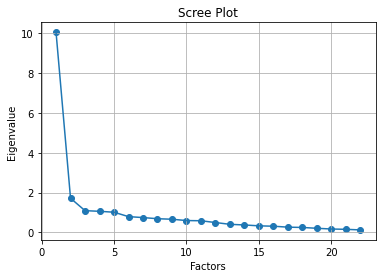

In [81]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

fa = FactorAnalyzer()
fa.fit(man)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.scatter(range(1, man.shape[1]+1), ev)
plt.plot(range(1, man.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [82]:
n_factors = 6
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors, method='ml')
fa.fit(man)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='ml', n_factors=6, rotation='varimax', rotation_kwargs={},
               use_smc=True)

In [88]:
fa_data = pd.DataFrame(
    fa.loadings_,
    columns=[f'FA{fa}' for fa in range(1, n_factors+1)],
    index=[man.columns]
)

fa_data['factor'] = fa_data.idxmax(axis=1)
fa_data = fa_data.sort_values(by=['factor'])
fa_data

,FA1,FA2,FA3,FA4,FA5,FA6,factor
column_16,0.613585,0.127848,0.255776,0.153672,0.181506,0.162944,FA1
column_18,0.515857,0.101301,0.101337,0.180853,0.051438,0.118327,FA1
column_19,0.531504,0.240294,0.204860,0.171866,0.466423,-0.056259,FA1
column_20,0.751096,0.285843,0.249624,0.192078,0.118807,0.077964,FA1
column_21,0.516065,0.082159,0.336169,0.143946,0.066247,0.060866,FA1
column_40,0.260925,0.458287,0.309611,0.359015,0.249973,0.359275,FA2
column_23,0.196200,0.815865,0.228236,0.310604,0.188557,0.054258,FA2
column_24,0.167329,0.716233,0.239984,0.413083,-0.029615,0.152950,FA2
column_28,0.256191,0.306006,0.252268,0.292698,0.209436,0.068042,FA2
column_15,0.260198,0.256751,0.272766,0.215696,0.185501,0.045038,FA3


### Factor resource data

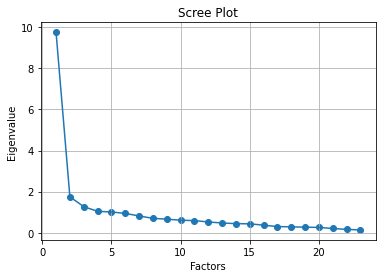

In [90]:
fa = FactorAnalyzer()
fa.fit(rec)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.scatter(range(1, rec.shape[1]+1), ev)
plt.plot(range(1, rec.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [93]:
n_factors = 3
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors, method='ml')
fa.fit(rec)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='ml', n_factors=3, rotation='varimax', rotation_kwargs={},
               use_smc=True)

In [94]:
fa_data = pd.DataFrame(
    fa.loadings_,
    columns=[f'FA{fa}' for fa in range(1, n_factors+1)],
    index=[rec.columns]
)

fa_data['factor'] = fa_data.idxmax(axis=1)
fa_data = fa_data.sort_values(by=['factor'])
fa_data

,FA1,FA2,FA3,factor
column_15,0.447802,0.204370,0.244093,FA1
column_31,0.572599,0.099787,0.492729,FA1
column_28,0.342176,0.191311,0.130085,FA1
column_27,0.325009,0.143305,0.174589,FA1
column_25,0.702821,0.467501,0.106803,FA1
column_24,0.819685,0.389471,0.067123,FA1
column_23,0.852715,0.189815,0.072173,FA1
column_26,0.612765,0.297821,0.266701,FA1
column_21,0.318828,0.494417,0.259943,FA2
column_20,0.466031,0.645029,0.224751,FA2
